## Machine learning completion of the project: The SECOM data set

* The SECOM data set contains 1567 examples that originate from a production line for wafer manufacture. 
* Each example is a vector of 590 sensor measurements plus an identification of the pass / fail test. 
* Among the 1567 examples, there are only 104 failed cases marked positive (coded as 1), while a much larger number of examples pass the test and are marked negative (coded as -1). 
* The imbalance between passed and failed examples, as well as the large amount of measurement data obtained from hundreds of sensors, make it difficult to analyze this data set precisely.

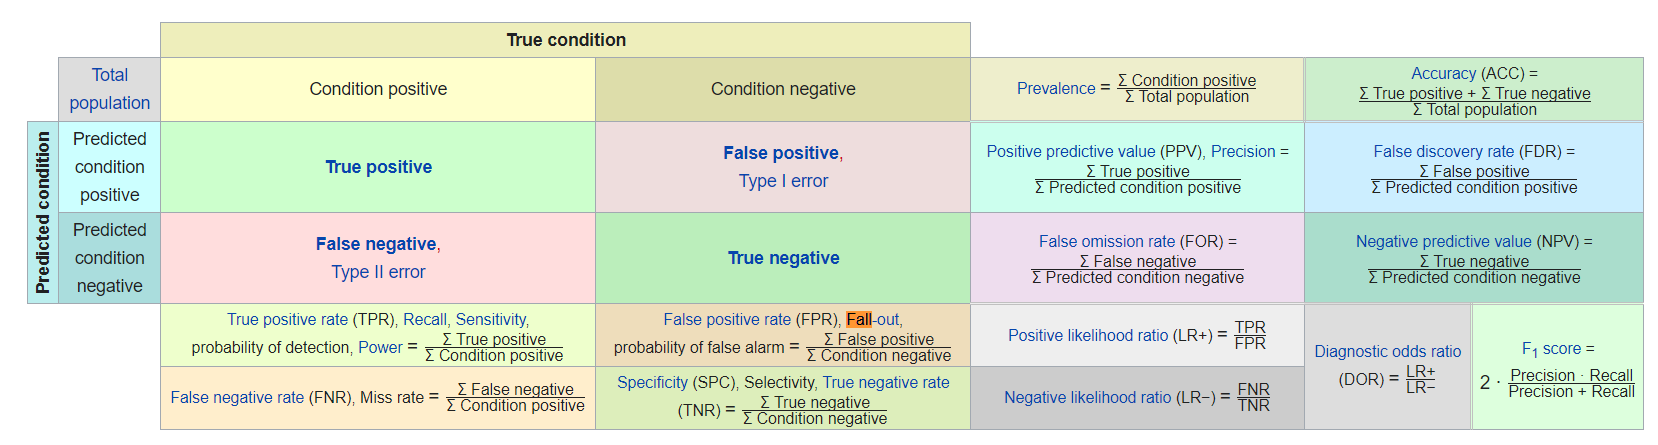

### Import and Load

In [ ]:
# for basic operations
import numpy as np 
import pandas as pd 

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
# plt.style.use('fivethirtyeight')

# for modeling 
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
# from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import OneClassSVM

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

In [ ]:
data = pd.read_csv("../input/uci-semcom/uci-secom.csv")
data

In [ ]:
data = data.rename({"Pass/Fail":'Pass_Fail'},axis=1)

## Data Cleaning

In [ ]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

display(summary(data).sort_values(by='Nulls', ascending=False))

### Missing Values

In [ ]:
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [ ]:
df_na = null_values(data)
df_na

In [ ]:
df_na = df_na[df_na["Percentage (%)"] > 50]
df_na

In [ ]:
df_na.shape

#### There are 28 columns that contain more than 50% NAs. These must be removed.

In [ ]:
df_na.index

In [ ]:
data = data.drop(axis=1, columns=df_na.index)
data.shape

#### 28 columns with more than 50% NAs were removed

In [ ]:
data.head()

#### Missing values must be fill

In [ ]:
#strategy 1: latest information available
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)
data

Now we have a cleaner data set. No NaN values.

In [ ]:
null_values(data)

In [ ]:
data.shape

### Unique values in columns

In [ ]:
data["5"].nunique()

In [ ]:
def unique_columns(df):
    """a function to show unique columns with column name"""
    uni_col_list = []
    for column in df.columns:
        if df[column].nunique() == 1:
            uni_col_list.append(column)
    return uni_col_list

In [ ]:
len(unique_columns(data))

#### There are 116 columns that contain unique values. These columns must be removed.  

In [ ]:
data["179"].nunique()

In [ ]:
data.shape

In [ ]:
data = data.drop(axis=1, columns=unique_columns(data))
data.shape

In [ ]:
# We will not use the "Time" column in the following steps, so this column can be completely deleted.
data.drop(columns="Time", axis=1, inplace=True)
data.shape

In [ ]:
data.info()

#### We now have cleaner records than before. All values are metric and not NA values.
- We have 1567 rows and 447 columns before modeling

### EDA (Exploratory Data Analysis)

In [ ]:
# pie chart
# We have highly imbalanced class with only 6.6% failures and 93.4% pass

plt.rcParams['figure.figsize'] = (5,5)
labels = ['Pass', 'Fail']
size = data['Pass_Fail'].value_counts()
colors = ['blue', 'green']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()
data["Pass_Fail"].value_counts()

**There is unbalanced record. The Failing Values are only 104. Data balancing must be applied**

In [ ]:
data.corr()["Pass_Fail"].sort_values()

**Neither column has a great correlation with Pass_Fail**

## Data Cleaning/Preprocessing

In [ ]:
# Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [ ]:
#Remove columns having more than 70% correlation
#Both positive and negative correlations are considered here
data = remove_collinear_features(data,0.70)

In [ ]:
data.shape

## Iteration 1: (Unbalanced data)

### Split data

In [ ]:
# from sklearn.model_selection import train_test_split

In [ ]:
# separating the dependent and independent data
X = data.drop('Pass_Fail', axis=1)
y = data['Pass_Fail']

# getting the shapes of new data sets x and y
print("shape of X:", X.shape)
print("shape of y:", y.shape)

In [ ]:
# the function train_test_split creates random data samples (default: 75-25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)  # seed for comparable results

In [ ]:
# gettiing the shapes
print("shape of X_train: ", X_train.shape)
print("shape of X_test: ", X_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

In [ ]:
# Let's check if the pass / fail ratio is preserved in y_test data.
size = y_test.value_counts()
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('y_test: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()

### Data Scaling

In [ ]:
# standardization
# from sklearn.preprocessing import StandardScaler

# creating a standard scaler
sc = StandardScaler()

# fitting independent data to the model
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**Lazy Predict**

In [ ]:
# import lazypredict
# from lazypredict.Supervised import LazyClassifier
# from sklearn.utils.testing import ignore_warnings

# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit (X_train, X_test, y_train, y_test)
# models

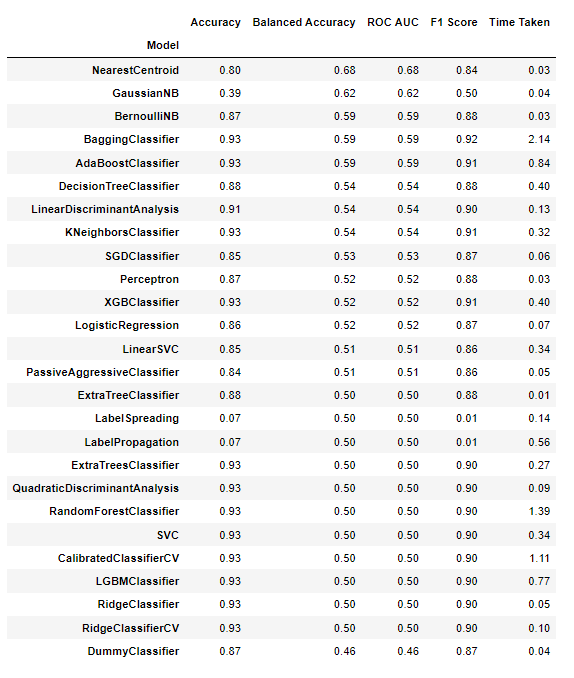

### Use algorithms

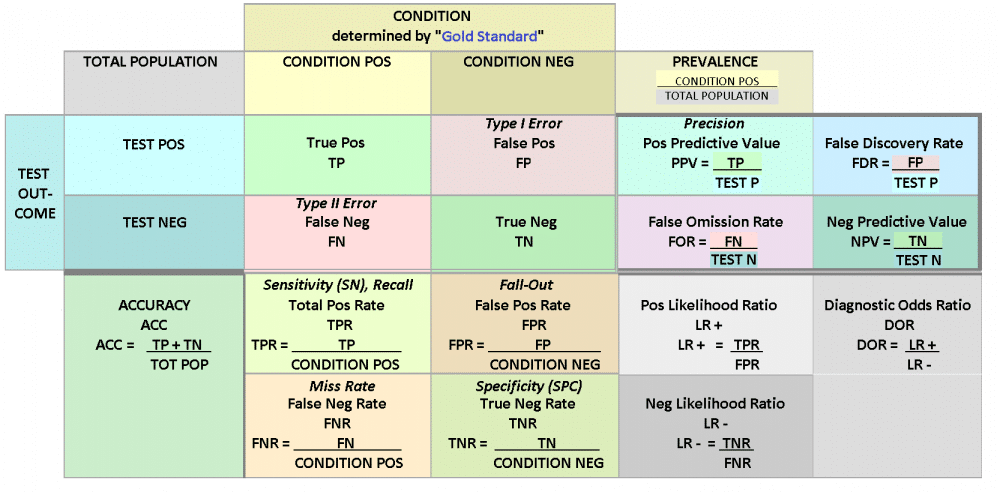

In [ ]:
cv_acc = {}
cv_TPR = {}
cv_FPR = {}

In [ ]:
def plot_result(model, name:str):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores = cross_val_score(model, X_test, y_test, cv=10, scoring = 'balanced_accuracy')
    cv_acc[name] = round(scores.mean(), 4)*100  # balanced accuracy
    cv_TPR[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (Max)
    cv_FPR[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (Min)
    print('Average Balanced Accuracy (CV=10):', scores.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot Confusion Matrix
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()

##### 1-Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

In [ ]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)
plot_result(dtc, "dtc")

In [ ]:
# plot tree
plt.figure(figsize=(16,6))
plot_tree(dtc, filled = True, class_names=["-1", "1"], feature_names=X.columns, fontsize=11);

In [ ]:
cv_acc

In [ ]:
cv_FPR

In [ ]:
cv_TPR

##### 2-Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(max_iter=150)
plot_result(lr, "lr")

##### 3-SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(C=1.0, kernel='rbf', gamma='scale')  # default values
plot_result(svc, "svc")

##### 4-Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None)
plot_result(rfc, "rfc")

In [ ]:
def plot_feature_importances(model):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:10]

    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

    print(f"Top 10 Feature Importance for {str(model).split('(')[0]}\n\n",feature_imp[:10],sep='')

In [ ]:
plot_feature_importances(rfc)

##### 5-Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=3, random_state=42)
plot_result(gbc, "gbc")

In [ ]:
plot_feature_importances(gbc)

##### 6-Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
nb = GaussianNB()
plot_result(nb, "nb")

##### 7-kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
plot_result(knn, "knn")

**8-XGBOOST**

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

In [ ]:
xgb = XGBClassifier(eval_metric = "logloss")
plot_result(xgb, "xgb")

In [ ]:
plot_feature_importances(xgb)

In [ ]:
from xgboost import plot_importance
plot_importance(xgb,max_num_features=10)
plt.xlabel('The F-Score for each features')
plt.ylabel('Importances')
plt.show()

### Evaluation (iteration 1)

In [ ]:
cv_acc

In [ ]:
cv_TPR

In [ ]:
cv_FPR

In [ ]:
cv_FPR.values()

In [ ]:
df_eval = pd.DataFrame(data={'model': list(cv_acc.keys()), 'bal_acc': list(cv_acc.values()), 'recall': list(cv_TPR.values()), 'fallout':list(cv_FPR.values())})
df_eval

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(14, 4))
sns.barplot(x="bal_acc", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0])
ax[0].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[1])
ax[1].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[2])
ax[2].set_title("Unbalanced Test FPR")
plt.show()

NaiveBayes gave high BalanceAccuracy and TPR_Score (Recall), but it gave the poor FPR_Score (Fallout) in this unbalanced data set.

## Iteration 2: (with SMOTE)

### Balancing data

In [ ]:
y_test.value_counts(normalize=True)

In [ ]:
y_train.value_counts(normalize=True)

In [ ]:
# pip install imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [ ]:
oversmote = SMOTE()
X_train_os, y_train_os= oversmote.fit_resample(X_train, y_train)

In [ ]:
y_train_os.value_counts().plot.bar(color=["blue", "red"])
plt.show()

In [ ]:
X_train_os.shape

### Use algorithms

In [ ]:
cv_acc_balance = {}
cv_TPR_balance = {}
cv_FPR_balance = {}

In [ ]:
def plot_result_smote(model, name:str):
    model.fit(X_train_os, y_train_os)
    y_pred = model.predict(X_test)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores = cross_val_score(model, X_test, y_test, cv=10, scoring = 'balanced_accuracy')
    cv_acc_balance[name] = round(scores.mean(), 4)*100  # balanced accuracy
    cv_TPR_balance[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (maximieren)
    cv_FPR_balance[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (minimieren)
    print('Average Balanced Accuracy (CV=10):', scores.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot Confusion Matrix
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()

In [ ]:
# Decision tree
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)

plot_result_smote(dtc, "dtc")

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=200)
plot_result_smote(lr, "lr")

In [ ]:
# SVC
svc = SVC(C=1.0, kernel='rbf', gamma='scale')  # default Werte
plot_result_smote(svc, "svc")

In [ ]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None)
plot_result_smote(rfc, "rfc")

In [ ]:
# Gradient Boost
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=3, random_state=42)
plot_result_smote(gbc, "gbc")

In [ ]:
# Naive Bayes
nb = GaussianNB()
plot_result_smote(nb, "nb")

In [ ]:
# kNN
knn = KNeighborsClassifier(n_neighbors=3)
plot_result_smote(knn, "knn")

In [ ]:
# XGBOOST
xgb = XGBClassifier(eval_metric = "logloss",n_estimators=25, learning_rate=0.01,  max_depth=3, random_state=42)
plot_result_smote(xgb, "xgb")

In [ ]:
cv_acc

In [ ]:
df_eval_smote = pd.DataFrame(data={'model': list(cv_acc_balance.keys()), 'bal_acc': list(cv_acc_balance.values()), 'recall': list(cv_TPR_balance.values()), 'fallout':list(cv_FPR_balance.values())})
df_eval_smote

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))
sns.barplot(x="bal_acc", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,1])
ax[0,1].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,2])
ax[0,2].set_title("Unbalanced Test FPR")
sns.barplot(x="bal_acc", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,0])
ax[1,0].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,1])
ax[1,1].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,2])
ax[1,2].set_title("Smote Model Test FPR")
plt.tight_layout()
plt.show()

GradientBoosting yielded the optimized result as better FPR and relative mean strong recall scores. The balance accuracy is also relatively good.

## Iteration 3: (with SMOTE and Feature Selection Filter method)

In [ ]:
from scipy.stats import pearsonr

In [ ]:
df_filtered = pd.DataFrame(X_train_os).apply(lambda x: pd.Series(pearsonr(x, y_train_os), index=[0, 1]), axis =0).T.applymap(lambda x: np.round(x,3)).sort_values(by=1, ascending=False)
df_filtered

In [ ]:
df_filtered = df_filtered[df_filtered[1] <= 0.05]
df_filtered

In [ ]:
df_filtered.index

In [ ]:
X_train_os_selected_filter = pd.DataFrame(X_train_os)[df_filtered.index]
X_test_fe = pd.DataFrame(X_test)[df_filtered.index]
X_train_os_selected_filter

#### Use Algorithm

In [ ]:
cv_acc_balance_fe = {}
cv_TPR_balance_fe = {}
cv_FPR_balance_fe = {}

In [ ]:
def plot_result_smoted_fe(model, name:str):
    model.fit(X_train_os_selected_filter, y_train_os)
    y_pred = model.predict(X_test_fe)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores = cross_val_score(model, X_test_fe, y_test, cv=10, scoring = 'balanced_accuracy')
    cv_acc_balance_fe[name] = round(scores.mean(), 4)*100  # balanced accuracy
    cv_TPR_balance_fe[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (maximize)
    cv_FPR_balance_fe[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (minimize)
    print('Average Balanced Accuracy (CV=10):', scores.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot Confusion Matrix
    plt.figure(figsize=(3,3))
    plot_confusion_matrix(model, X_test_fe, y_test)
    plt.show()

In [ ]:
# Decision tree
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)

plot_result_smoted_fe(dtc, "dtc")

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=200)
plot_result_smoted_fe(lr, "lr")

In [ ]:
# SVC
svc = SVC(C=1.0, kernel='rbf', gamma='scale')  # default Werte
plot_result_smoted_fe(svc, "svc")

In [ ]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None)
plot_result_smoted_fe(rfc, "rfc")

In [ ]:
# Gradient Boost
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=3, random_state=42)
plot_result_smoted_fe(gbc, "gbc")

In [ ]:
# Naive Bayes
nb = GaussianNB()
plot_result_smoted_fe(nb, "nb")

In [ ]:
# kNN
knn = KNeighborsClassifier(n_neighbors=3)
plot_result_smoted_fe(knn, "knn")

In [ ]:
# XGBOOST
xgb = XGBClassifier(eval_metric = "logloss",n_estimators=25, learning_rate=0.01,  max_depth=3, random_state=42)
plot_result_smoted_fe(xgb, "xgb");

In [ ]:
df_eval_smote_fe = pd.DataFrame(data={'model': list(cv_acc_balance.keys()), 'bal_acc': list(cv_acc_balance.values()), 'recall': list(cv_TPR_balance.values()), 'fallout':list(cv_FPR_balance.values())})
df_eval_smote_fe

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(16, 8))
sns.barplot(x="bal_acc", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,1])
ax[0,1].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,2])
ax[0,2].set_title("Unbalanced Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,0])
ax[1,0].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,1])
ax[1,1].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,2])
ax[1,2].set_title("Smote Model Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,0])
ax[2,0].set_title("Smoted_Featured Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,1])
ax[2,1].set_title("Smoted_Featured Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,2])
ax[2,2].set_title("Smoted_Featured Model Test FPR")

plt.tight_layout()
plt.show()

According to Smote and Feature Selection with Pearson Correlation, nb gave the better result for recall and fallout.

## Iteration 4: (with SMOTE and PCA)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X_train_os

In [ ]:
pca = PCA().fit(X_train_os)

we know that the principal components explain a part of the variance. From the Scikit-learn implementation, we can get the information about the explained variance and plot the cumulative variance. The PCA algorithm is going to standardize the input data frame, calculate the covariance matrix of the features. Thanks to [Mikulski](https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/)

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
xi = np.arange(0, 160, step=1)
y = np.cumsum(pca.explained_variance_ratio_[0:160:1])

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='.', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 160, step=2), rotation=90) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

It looks like n_components = 145 is suitable for% 95 total explained variance,

In [ ]:
pca = PCA(n_components=145)
pca.fit(X_train_os)
per_var = np.round(pca.explained_variance_ratio_ * 100, 1)
labels = ['PC' + str(x) for x in range(1,len(per_var)+1)]

plt.figure(figsize=(20,6))
plt.bar(x=range(len(per_var)), height=per_var, tick_label=labels)
plt.title('Total explained variance {}'.format(np.round(sum(per_var),2)))
plt.ylabel('Explained variance in percent')
plt.xticks(rotation=90)
plt.show()

In [ ]:
X_train_os_pca = pca.transform(X_train_os)
pd.DataFrame(X_train_os_pca)

The loads (loading scores) indicate "how high a variable X loads on a factor Y". 

(The i-th principal components can be selected via i in pca.components_ [0].)

In [ ]:
# Top 20 columns that have the greatest impact
loading_scores = pd.Series(pca.components_[0], index=X.columns)
loading_scores.abs().sort_values(ascending=False)[:20]

#### Use Algorithm

In [ ]:
X_test_pca = pca.transform(X_test)

In [ ]:
cv_acc_balance_pca = {}
cv_TPR_balance_pca = {}
cv_FPR_balance_pca = {}

In [ ]:
def plot_result_smoted_pca(model, name:str):
    model.fit(X_train_os_pca, y_train_os)
    y_pred = model.predict(X_test_pca)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores = cross_val_score(model, X_test_pca, y_test, cv=10, scoring = 'balanced_accuracy')
    cv_acc_balance_pca[name] = round(scores.mean(), 4)*100  # balanced accuracy
    cv_TPR_balance_pca[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (max)
    cv_FPR_balance_pca[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (min)
    print('Average Balanced Accuracy (CV=10):', scores.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot confusion matrix
    plt.figure(figsize=(3,3))
    plot_confusion_matrix(model, X_test_pca, y_test)
    plt.show()

In [ ]:
# Decision tree
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)

plot_result_smoted_pca(dtc, "dtc")

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=200)
plot_result_smoted_pca(lr, "lr")

In [ ]:
# SVC
svc = SVC(C=1.0, kernel='rbf', gamma='scale')  # default Werte
plot_result_smoted_pca(svc, "svc")

In [ ]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None)
plot_result_smoted_pca(rfc, "rfc")

In [ ]:
# Gradient Boost
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=3, random_state=42)
plot_result_smoted_pca(gbc, "gbc")

In [ ]:
# Naive Bayes
nb = GaussianNB()
plot_result_smoted_pca(nb, "nb")

In [ ]:
# kNN
knn = KNeighborsClassifier(n_neighbors=3)
plot_result_smoted_pca(knn, "knn")

In [ ]:
# XGBOOST
xgb = XGBClassifier(eval_metric = "logloss",n_estimators=25, learning_rate=0.01,  max_depth=3, random_state=42)
plot_result_smoted_pca(xgb, "xgb");

In [ ]:
df_eval_smote_pca = pd.DataFrame(data={'model': list(cv_acc_balance.keys()), 'bal_acc': list(cv_acc_balance.values()), 'recall': list(cv_TPR_balance.values()), 'fallout':list(cv_FPR_balance.values())})
df_eval_smote_pca

In [ ]:
fig, ax = plt.subplots(4,3, figsize=(16, 10))

sns.barplot(x="bal_acc", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,1])
ax[0,1].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,2])
ax[0,2].set_title("Unbalanced Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,0])
ax[1,0].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,1])
ax[1,1].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,2])
ax[1,2].set_title("Smote Model Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,0])
ax[2,0].set_title("Smoted_Featured Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,1])
ax[2,1].set_title("Smoted_Featured Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,2])
ax[2,2].set_title("Smoted_Featured Model Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,0])
ax[3,0].set_title("Smoted_PCA Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,1])
ax[3,1].set_title("Smoted_PCA Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,2])
ax[3,2].set_title("Smoted_PCA Model Test FPR")

plt.tight_layout()
plt.show()

According to Smote and PCA, none of the models really gave relatively good results.

In [ ]:
df_eval["type"] = "Unbalanced"
df_eval_smote["type"] = "Smote"
df_eval_smote_fe["type"] = "Smote_FE"
df_eval_smote_pca["type"] = "Smote_PCA"

In [ ]:
frames = [df_eval, df_eval_smote, df_eval_smote_fe, df_eval_smote_pca]
df_result = pd.concat(frames, ignore_index=True)
df_result['model'] = df_result['model'].str.upper()
df_result[["recall", "fallout", "bal_acc"]] = df_result[["recall", "fallout", "bal_acc"]].apply(lambda x: np.round(x, 2))

In [ ]:
sns.relplot(x="recall", y="fallout", hue="model", size="bal_acc", sizes=(40, 400), col="type", alpha=1, palette="bright", height=4, legend='full', data=df_result)

In this plot it looks like GradientBoosting in Smote has a better result

## Iteration 5: (with SMOTE_FE and hyperparameter optimization)

Smote_FE looks better than Smote_PCA. Hyperparameter is optimized by Smote_FE.

#### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
X_train_os_selected_filter

In [ ]:
X_test_fe

In [ ]:
# grid_searcher = GridSearchCV(svc, params, cv = 10, n_jobs=-1)
# grid_searcher.fit(X,y)

#### Use Algorithm

In [ ]:
cv_acc_balance_fe_tuned = {}
cv_TPR_balance_fe_tuned = {}
cv_FPR_balance_fe_tuned = {}

In [ ]:
def plot_result_smoted_fe_tuned(model, name:str):
    model.fit(X_train_os_selected_filter, y_train_os)
    y_pred = model.predict(X_test_fe)

    # Evaluation based on a 10-fold cross-validation
    scores = cross_val_score(model, X_test_fe, y_test, cv=10, scoring = 'balanced_accuracy')
    cv_acc_balance_fe_tuned[name] = round(scores.mean(), 4)*100  # balanced accuracy
    cv_TPR_balance_fe_tuned[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (max)
    cv_FPR_balance_fe_tuned[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (min)
    print('Average Balanced Accuracy (CV=10):', scores.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot confusion matrix
    plt.figure(figsize=(3,3))
    plot_confusion_matrix(model, X_test_fe, y_test)
    plt.show()

In [ ]:
# Decision Tree
params = {'criterion' : ["gini", "entropy"],
          'max_depth':[2, 3, 4, 5, 10], 
          'min_samples_leaf':[100, 50, 10, 1],
          'min_samples_split':[2, 4, 8, 16]}

grid_searcher = GridSearchCV(DecisionTreeClassifier(), params)
grid_searcher.fit(X_train_os_selected_filter, y_train_os)
#plot_result_smoted_fe_tuned(grid_searcher, "dtc")

In [ ]:
grid_searcher.best_params_

In [ ]:
grid_searcher.best_estimator_

In [ ]:
plot_result_smoted_fe_tuned(grid_searcher.best_estimator_, "dtc")

In [ ]:
# Logistic Regression
params = {'penalty' : ['l1', 'l2'],
          'C' : np.logspace(-4, 4, 20),
          'max_iter':[200, 300],
          'solver' : ['liblinear']}

grid_searcher = GridSearchCV(LogisticRegression(), params)
grid_searcher.fit(X_train_os_selected_filter, y_train_os)

print(grid_searcher.best_estimator_)
plot_result_smoted_fe_tuned(grid_searcher.best_estimator_, "lr")

In [ ]:
# SVC
params = {'kernel':(['linear','rbf']), 
          'C':[0.001, 0.01, 0.1, 1, 10, 100], 
          'gamma':[0.001, 0.01, 0.1, 1]}

grid_searcher = GridSearchCV(SVC(), params)
grid_searcher.fit(X_train_os_selected_filter, y_train_os)

print(grid_searcher.best_estimator_)
plot_result_smoted_fe_tuned(grid_searcher.best_estimator_, "svc")

In [ ]:
# Random Forest
params={'criterion': ['entropy', 'gini'],
        'n_estimators' : list(range(10,101,10)),
        'max_features' : list(range(6,32,5))}

grid_searcher = GridSearchCV(RandomForestClassifier(), params)
grid_searcher.fit(X_train_os_selected_filter, y_train_os)

print(grid_searcher.best_estimator_)
plot_result_smoted_fe_tuned(grid_searcher.best_estimator_, "rfc")

In [ ]:
# These parameters could not be optimized with GridSearch because it took longer than intended. 
# Then new Parameter manual was tried again

# params={
#        "learning_rate": [1],
#       "min_samples_split": [50, 10, 2],
#        "min_samples_leaf": [1, 5, 10],
#        "max_depth":[3,4,5],
#        "subsample":[0.5, 1.0],
#        "n_estimators":[10, 50, 100],
#        "random_state":[42]}

gbc = GradientBoostingClassifier(learning_rate=1, max_depth=6, n_estimators=40, random_state=42)  # manually selected parameters
# grid_searcher = GridSearchCV(GradientBoostingClassifier(), params)
# grid_searcher.fit(X_train_os_selected_filter, y_train_os)

# print(grid_searcher.best_estimator_)
plot_result_smoted_fe_tuned(gbc, "gbc")

In [ ]:
# Naive Bayes has no tuning
nb = GaussianNB()
plot_result_smoted_fe_tuned(nb, "nb")

In [ ]:
# kNN
params = {'n_neighbors':[2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
         'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_searcher = GridSearchCV(KNeighborsClassifier(), params)
grid_searcher.fit(X_train_os_selected_filter, y_train_os)

print(grid_searcher.best_estimator_)
plot_result_smoted_fe_tuned(grid_searcher.best_estimator_, "knn")

In [ ]:
# XGBOOST
xgb = XGBClassifier(eval_metric = "logloss",n_estimators=25, learning_rate=0.01,  max_depth=3, random_state=42)
plot_result_smoted_fe_tuned(xgb, "xgb");

In [ ]:
df_eval_smote_fe_tuned = pd.DataFrame(data={'model': list(cv_acc_balance.keys()), 'bal_acc': list(cv_acc_balance.values()), 'recall': list(cv_TPR_balance.values()), 'fallout':list(cv_FPR_balance.values())})
df_eval_smote_fe_tuned

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(16, 10))

sns.barplot(x="bal_acc", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,1])
ax[0,1].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,2])
ax[0,2].set_title("Unbalanced Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,0])
ax[1,0].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,1])
ax[1,1].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,2])
ax[1,2].set_title("Smote Model Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,0])
ax[2,0].set_title("Smoted_Featured Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,1])
ax[2,1].set_title("Smoted_Featured Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_fe.sort_values(by="recall"), ax=ax[2,2])
ax[2,2].set_title("Smoted_Featured Model Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,0])
ax[3,0].set_title("Smoted_PCA Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,1])
ax[3,1].set_title("Smoted_PCA Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,2])
ax[3,2].set_title("Smoted_PCA Model Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote_fe_tuned.sort_values(by="recall"), ax=ax[4,0])
ax[4,0].set_title("Smoted_FE_Tuned Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_fe_tuned.sort_values(by="recall"), ax=ax[4,1])
ax[4,1].set_title("Smoted_FE_Tuned Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_fe_tuned.sort_values(by="recall"), ax=ax[4,2])
ax[4,2].set_title("Smoted_FE_Tuned Model Test FPR")

plt.tight_layout()
plt.show()

In [ ]:
df_eval_smote_fe_tuned["type"] = "Smote_FE_Tuned"

In [ ]:
frames = [df_eval, df_eval_smote, df_eval_smote_fe, df_eval_smote_pca, df_eval_smote_fe_tuned]
df_result = pd.concat(frames, ignore_index=True)
df_result['model'] = df_result['model'].str.upper()
df_result[["recall", "fallout", "bal_acc"]] = df_result[["recall", "fallout", "bal_acc"]].apply(lambda x: np.round(x, 2))
df_result

In [ ]:
sns.relplot(x="recall", y="fallout", hue="model", size="bal_acc", sizes=(40, 400), col="type", alpha=1, palette="bright", height=4, legend='full', data=df_result)

#### Summary: 
In this project the SECOM dataset was analyzed by machine learning methods with 5 iterations as a classification. For each iteration one tried little by little to achieve a better model result. Therefore 7 different algorithms (DecisionTree, Logistic Regression, Support Vector Machine, Random Forest, Gradient Boost, NaiveBayes and kNearestNeigbour) were used. After the data cleaning and EDA process, the data set was scaled with StandartScaler because there were many large and small features. After that, something special (oversampling, FeatureSelection, FeatureExtraction, HyperParameter optimization) was applied in each iteration. In the end, GradientBoost with only oversampled and scaled data set gave better results. The outliers can be checked for the next iteration and for each column one should decide whether 1.5xquarter is the correct limit for the real outliers.  

## THE END. THANK YOU FOR YOUR ATTENTION.

## Extra section: Handling outliers

In [ ]:
data

In [ ]:
sns.boxplot(x=data['0'], whis=2);

In [ ]:
sns.boxplot(x=data['Pass_Fail'], whis=2);

#### z-score
The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

In [ ]:
from scipy import stats

z = np.abs(stats.zscore(data))
print(z)

In [ ]:
z[0][1]

In [ ]:
threshold = 3
print(np.where(z > 3))

The first array contains the list of row numbers and second array respective column numbers, which means a Z-score higher than 3.

In [ ]:
print(z[0][82])  # So, the data point — 0th record on column 82 is an outlier.

In [ ]:
data_o = data[(z < 3).all(axis=1)]

In [ ]:
data_o.shape

Our record rose to 267 lines

In [ ]:
sns.boxplot(x=data_o['0'], whis=2);

In [ ]:
sns.countplot(data_o.Pass_Fail);

All 1 values have been deleted, so you have to work with X again

In [ ]:
X = data.drop('Pass_Fail', axis=1)
y = data['Pass_Fail']

In [ ]:
from scipy import stats

z = np.abs(stats.zscore(X))
print(z)

In [ ]:
X_o = X[(z < 3).all(axis=1)]
X_o.shape

In [ ]:
X_o.index

In [ ]:
y_o = y.iloc[X_o.index]

In [ ]:
sns.countplot(y_o);

##### IQR Score

In [ ]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

In [ ]:
((X < (Q1 - 2 * IQR)) | (X > (Q3 + 2 * IQR)))

In [ ]:
X_out = X[~((X < (Q1 - 2.5 * IQR)) | (X > (Q3 + 2.5 * IQR))).any(axis=1)]
X_out.shape

In [ ]:
X_out

You could get 137 lines with just 2.5 whiskers. This number of records will not be enough. 

#### Then data scaled with z_score are processed further.

##### The data is split using the train_test_split function.

In [ ]:
# the function train_test_split creates random data samples (default: 75-25%)
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_o, y_o, stratify=y_o, random_state=42)  # seed for comparable results

In [ ]:
X_train_o.shape

In [ ]:
y_test_o.value_counts().plot.bar();

In [ ]:
y_train_o.value_counts().plot.bar();

### Scaling Data

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
std_scale = StandardScaler().fit(X_train_o)
X_train_o_scaled = std_scale.transform(X_train_o)
pd.DataFrame(X_train_o_scaled).head()

In [ ]:
X_test_o_scaled = std_scale.transform(X_test_o)
pd.DataFrame(X_test_o_scaled).head()

#### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
oversmote = SMOTE()
X_train_os, y_train_os= oversmote.fit_resample(X_train_o_scaled, y_train_o)

In [ ]:
y_train_os.value_counts().plot.bar(color=["blue", "red"])
plt.show()

In [ ]:
X_train_os.shape

### Use Algorithm

In [ ]:
cv_acc_balance_o = {}
cv_TPR_balance_o = {}
cv_FPR_balance_o = {}

In [ ]:
def plot_result_smote_o(model, name:str):
    model.fit(X_train_os, y_train_os)
    y_pred = model.predict(X_test_o_scaled)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores = cross_val_score(model, X_test_o_scaled, y_test_o, cv=10, scoring = 'balanced_accuracy')
    cv_acc_balance_o[name] = round(scores.mean(), 4)*100  # balanced accuracy
    cv_TPR_balance_o[name] = (confusion_matrix(y_test_o, y_pred)[1][1]/confusion_matrix(y_test_o, y_pred)[1].sum())*100  # recall (max)
    cv_FPR_balance_o[name] = (confusion_matrix(y_test_o, y_pred)[0][1]/confusion_matrix(y_test_o, y_pred)[0].sum())*100  # fallout (min)
    print('Aerage Balanced Accuracy (CV=10):', scores.mean())

    # print classification report
    print(classification_report(y_test_o, y_pred, zero_division=0))

    # Plot Confusion matrix
    plot_confusion_matrix(model, X_test_o_scaled, y_test_o)
    plt.show()

In [ ]:
# Decision Tree
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)

plot_result_smote_o(dtc, "dtc")

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=200)
plot_result_smote_o(lr, "lr")

In [ ]:
# SVC
svc = SVC(C=1.0, kernel='rbf', gamma='scale')  # default Werte
plot_result_smote_o(svc, "svc")

In [ ]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None)
plot_result_smote_o(rfc, "rfc")

In [ ]:
# Gradient Boost
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=3, random_state=42)
plot_result_smote_o(gbc, "gbc")

In [ ]:
# Naive Bayes
nb = GaussianNB()
plot_result_smote_o(nb, "nb")

In [ ]:
# kNN
knn = KNeighborsClassifier(n_neighbors=3)
plot_result_smote_o(knn, "knn")

In [ ]:
# XGBOOST
xgb = XGBClassifier(eval_metric = "logloss",n_estimators=25, learning_rate=0.01,  max_depth=3, random_state=42)
plot_result_smote_o(xgb, "xgb");

In [ ]:
df_eval_smote_o = pd.DataFrame(data={'model': list(cv_acc_balance.keys()), 'bal_acc': list(cv_acc_balance.values()), 'recall': list(cv_TPR_balance.values()), 'fallout':list(cv_FPR_balance.values())})
df_eval_smote_o

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(16, 8))
sns.barplot(x="bal_acc", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,1])
ax[0,1].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,2])
ax[0,2].set_title("Unbalanced Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,0])
ax[1,0].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,1])
ax[1,1].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,2])
ax[1,2].set_title("Smote Model Test FPR")

sns.barplot(x="bal_acc", y="model", data=df_eval_smote_o.sort_values(by="recall"), ax=ax[2,0])
ax[2,0].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_o.sort_values(by="recall"), ax=ax[2,1])
ax[2,1].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_o.sort_values(by="recall"), ax=ax[2,2])
ax[2,2].set_title("Smote Model Test FPR")

plt.tight_layout()
plt.show()

SVC looks good, less FPR and large TPR with relatively good balance accuracy

### Many Thanks.